In [5]:
import os
import sklearn
import gc
import matplotlib.pyplot as plt
import ast
import time

import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb

from sklearn.externals import joblib
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, accuracy_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from catboost import CatBoostRegressor, CatBoostClassifier
from xgboost import XGBClassifier, XGBRegressor

def plot_fe(series, xlabel='', ylabel='', title='', figsize=(13, 10), font_size=14, sort=True):
    if sort:
        series = series.sort_values(ascending=False)
        
    plt.figure(figsize=figsize);
    sns.set(font_scale=font_size/10.0)
    ax = sns.barplot(x=series.values.reshape(1, -1)[0], y=series.index);
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=font_size)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=font_size)
    if title:
        ax.set_title(title, fontsize=font_size)
    plt.show()
    
# %config IPCompleter.greedy=True

# Define some helper functions

In [6]:
# functions for predicting bookmakers probability
def preproc(lcldf, cols):
    kefs = pd.read_csv('./data/csgoKefs.csv', sep=';')
    kefs['kefs'] = kefs['kefs'].apply(lambda x: np.array(ast.literal_eval(x)))
    kefs['teamAkef'] = kefs['kefs'].apply(lambda x: np.median(x.T[0]))
    kefs['teamBkef'] = kefs['kefs'].apply(lambda x: np.median(x.T[1]))
    kefs['teamAperMarja'] = 1/kefs['teamAkef'].values
    kefs['teamBperMarja'] = 1/kefs['teamBkef'].values
    kefs['teamAper'] = kefs['teamAperMarja'].values/(kefs['teamAperMarja'].values + kefs['teamBperMarja'].values)
    kefs['teamBper'] = kefs['teamBperMarja'].values/(kefs['teamAperMarja'].values + kefs['teamBperMarja'].values)

    # kefs['teamAkef'] = kefs['kefs'].apply(lambda x: np.min(x.T[0]))
    # kefs['teamBkef'] = kefs['kefs'].apply(lambda x: np.min(x.T[1]))

    kefs['teamAkef'] = np.minimum(kefs['teamAkef'].values, [7]*kefs.shape[0])
    kefs['teamBkef'] = np.minimum(kefs['teamBkef'].values, [7]*kefs.shape[0])
    
#     ids = pd.read_csv('matchLinkIds.csv', sep=';')
#     newIndex = np.arange(ids.shape[0])
#     newIndex[::2] = ids.index.values[:ids.shape[0]//2]
#     newIndex[1::2] = ids.index.values[ids.shape[0]//2:]
#     ids.loc[ids.index] = ids.loc[newIndex].values
#     ids.reset_index(drop=True, inplace=True)
#     ids = ids.iloc[int(ids.shape[0]*0.1):]
#     ids.reset_index(drop=True, inplace=True)

# #     lcldf = pd.read_csv('elo0_1_1000_28RD.csv', sep=';')
# #     lcldf.rename(columns={'teamBRelativeForceWeightedNOHistoryW.1':'teamBRelativeForceNOHistorySpecW'}, inplace=True)
#     lcldf = pd.merge(lcldf, ids, left_index=True, right_index=True)
    lcldf = pd.merge(lcldf, kefs,  how='inner', left_on=['matchlinkId','teamAId', 'teamBId'], right_on = ['matchLinkId','teamAId', 'teamBId'])
    print lcldf.shape
    lcldf.drop(lcldf[(lcldf['teamAperMarja'] + lcldf['teamBperMarja']-1)<0].index, inplace=True)
    lcldf.drop_duplicates(['matchlinkId','teamAId', 'teamBId'], inplace=True)
    
    columnA = [i.replace('B', 'A') for i in cols + list(kefs.columns) if 'B' in i]
    columnB = [i for i in cols + list(kefs.columns) if 'B' in i]
    print columnA, columnB
    exchangeList = [1]*(len(columnA) + len(columnB))
    exchangeList[::2] = columnA
    exchangeList[1::2] = columnB
    exchangeList1 = [1]*(len(columnA) + len(columnB))
    exchangeList1[::2] = columnB
    exchangeList1[1::2] = columnA

    oversample = lcldf.copy()
    oversample[exchangeList] = oversample[exchangeList1]
    oversample['mapPicker'] = -1 * oversample['mapPicker'].values
    oversample.loc[oversample[oversample['difScore']>=-16].index, ['isWin', 'difScore']] = -1 * oversample.loc[oversample[oversample['difScore']>=-16].index, ['isWin', 'difScore']]
    lcldf = pd.concat([lcldf, oversample])
    # df.drop_duplicates(inplace=True)
    lcldf.reset_index(drop=True, inplace=True)
    return lcldf
    
def kefPrediction(lcldf, cols):
    lcldf = preproc(lcldf, cols)
    
    y_col = 'teamAper'

    trX, teX, trY, teY = preproc_data(lcldf, cols, y_col)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 21,
        'learning_rate': 0.03,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'verbose': 0,
        'n_jobs': 2,
    }
    kefPred = fit_model(params, trX, teX, trY, teY)

#     kefPred = XGBRegressor(max_depth=6, n_estimators=200, learning_rate=.06)
    
#     trX, teX, trY, teY = train_test_split(lcldf[cols].values, lcldf['teamAper'].values, test_size=0.3, stratify=None)
#     kefPred.fit(trX, trY)
#     pred = kefPred.predict(teX)
#     print mean_absolute_error(teY, pred)
#     pred = kefPred.predict(lcldf[cols].values)
#     print mean_absolute_error(pred, lcldf['teamAper'].values)
    return kefPred

In [7]:
def preproc_data(ldf, pred_clmns, y_col, test_size=0.2, random_state=523, cond=None):
    if cond is None:
        x_train, x_test, y_train, y_test = train_test_split(ldf[pred_clmns], ldf[y_col], test_size=test_size, random_state=random_state)
    else:
        
#     if 'alf' in y_col and 'istol' in y_col:
#         cond = ldf[y_col]!=0
        x_train, x_test, y_train, y_test = train_test_split(ldf[cond][pred_clmns], ldf[cond][y_col], test_size=test_size, random_state=random_state)
        
        
    print 'TRAIN SHAPE:', x_train.shape, 'TEST SHAPE:', x_test.shape
    if 'alf' in y_col and 'istol' in y_col:
        y_train.replace({-1: 0}, inplace=True)
        y_test.replace({-1: 0}, inplace=True)

    return x_train, x_test, y_train, y_test

def fit_model(params, x_train, x_test, y_train, y_test, weight_train=None, weight_test=None, modelname='lgb', cat_clmns=[]):
    if modelname=='lgb':
        # define lgb train and validation Datasets
        d_train = lgb.Dataset(x_train, y_train, weight=weight_train)
        d_valid = lgb.Dataset(x_test, y_test, weight=weight_test)

        # train model
        print '\nSTART FITTING:'
        model = lgb.train(params=params, 
                        train_set=d_train, 
                        num_boost_round=5000, 
                        valid_sets=[d_valid],
                        verbose_eval=100, 
                        early_stopping_rounds=25)
        print 'FITTING HAS BEEN ENDED\n'
        
        print 'VALIDATION:'
        if params['objective']=='binary':
            train_pred = model.predict(x_train)
            test_pred = model.predict(x_test)

            print 'TRAIN ROC_AUC:', round(roc_auc_score(y_train, train_pred), 6), 'ACCURACY:', round(accuracy_score(y_train, np.round(train_pred)), 6)
            print 'TEST ROC_AUC:', round(roc_auc_score(y_test, test_pred), 6), 'ACCURACY:', round(accuracy_score(y_test, np.round(test_pred)), 6)
            
        else:#params['objective']=='regression'
            train_pred = model.predict(x_train)
            test_pred = model.predict(x_test)

            print 'TRAIN MAE:', round(mean_absolute_error(y_train, train_pred), 6), 'MSE:', round(mean_squared_error(y_train, train_pred), 6)
            print 'TEST MAE:', round(mean_absolute_error(y_test, test_pred), 6), 'MSE:', round(mean_squared_error(y_test, test_pred), 6)
            
        return model
    
    elif modelname=='RandomForest':
        objective = params.pop('objective')
        if objective == 'binary':
            model = RandomForestClassifier(**params)
        else:
            model = RandomForestRegressor(**params)
        
        print '\nSTART FITTING:'
        model.fit(x_train, y_train)
        print 'FITTING HAS BEEN ENDED\n'
        
        print 'VALIDATION:'
        if objective == 'binary':
            train_pred = model.predict_proba(x_train).T[1]
            test_pred = model.predict_proba(x_test).T[1]
            
            print 'TRAIN ROC_AUC:', round(roc_auc_score(y_train, train_pred), 6), 'ACCURACY:', round(accuracy_score(y_train, np.round(train_pred)), 6)
            print 'TEST ROC_AUC:', round(roc_auc_score(y_test, test_pred), 6), 'ACCURACY:', round(accuracy_score(y_test, np.round(test_pred)), 6)
        else:
            train_pred = model.predict(x_train)
            test_pred = model.predict(x_test)

            print 'TRAIN MAE:', round(mean_absolute_error(y_train, train_pred), 6), 'MSE:', round(mean_squared_error(y_train, train_pred), 6)
            print 'TEST MAE:', round(mean_absolute_error(y_test, test_pred), 6), 'MSE:', round(mean_squared_error(y_test, test_pred), 6)
            
        return model
    
    elif modelname=='Linear':
        objective = params.pop('objective')
        if objective == 'binary':
            model = LogisticRegression(**params)
        else:
            model = LinearRegression(**params)
            
        #preproccessing
        continous_features = [i for i in x_train.columns if i not in cat_clmns]
        for cat_col in cat_clmns:
            _ = x_train[cat_col].unique()
            if _.shape[0]<=2:
                continue
            for value in _:
                x_train['%s_%s'%(cat_col, int(value))] = (x_train[cat_col] == value)*1
                x_test['%s_%s'%(cat_col, int(value))] = (x_test[cat_col] == value)*1
            x_train.drop(cat_col, axis=1, inplace = True)
            x_test.drop(cat_col, axis=1, inplace = True)
                
        standardScaler = StandardScaler()
        x_train[continous_features] = standardScaler.fit_transform(x_train[continous_features].values)
        x_test[continous_features] = standardScaler.transform(x_test[continous_features].values)
        
        print '\nSTART FITTING:'
        model.fit(x_train, y_train)
        print 'FITTING HAS BEEN ENDED\n'
        
        print 'VALIDATION:'
        if objective == 'binary':
            train_pred = model.predict_proba(x_train).T[1]
            test_pred = model.predict_proba(x_test).T[1]
            
            print 'TRAIN ROC_AUC:', round(roc_auc_score(y_train, train_pred), 6), 'ACCURACY:', round(accuracy_score(y_train, np.round(train_pred)), 6)
            print 'TEST ROC_AUC:', round(roc_auc_score(y_test, test_pred), 6), 'ACCURACY:', round(accuracy_score(y_test, np.round(test_pred)), 6)
        else:
            train_pred = model.predict(x_train)
            test_pred = model.predict(x_test)

            print 'TRAIN MAE:', round(mean_absolute_error(y_train, train_pred), 6), 'MSE:', round(mean_squared_error(y_train, train_pred), 6)
            print 'TEST MAE:', round(mean_absolute_error(y_test, test_pred), 6), 'MSE:', round(mean_squared_error(y_test, test_pred), 6)
            
        return model
    
    elif modelname=='DecisionTree':
        objective = params.pop('objective')
        if objective == 'binary':
            model = DecisionTreeClassifier(**params)
        else:
            model = DecisionTreeRegressor(**params)
        
        print '\nSTART FITTING:'
        model.fit(x_train, y_train)
        print 'FITTING HAS BEEN ENDED\n'
        
        print 'VALIDATION:'
        if objective == 'binary':
            train_pred = model.predict_proba(x_train).T[1]
            test_pred = model.predict_proba(x_test).T[1]
            
            print 'TRAIN ROC_AUC:', round(roc_auc_score(y_train, train_pred), 6), 'ACCURACY:', round(accuracy_score(y_train, np.round(train_pred)), 6)
            print 'TEST ROC_AUC:', round(roc_auc_score(y_test, test_pred), 6), 'ACCURACY:', round(accuracy_score(y_test, np.round(test_pred)), 6)
        else:
            train_pred = model.predict(x_train)
            test_pred = model.predict(x_test)

            print 'TRAIN MAE:', round(mean_absolute_error(y_train, train_pred), 6), 'MSE:', round(mean_squared_error(y_train, train_pred), 6)
            print 'TEST MAE:', round(mean_absolute_error(y_test, test_pred), 6), 'MSE:', round(mean_squared_error(y_test, test_pred), 6)
            
        return model
    
    elif modelname=='xgb':
        model = XGBRegressor(**params)
        
        print '\nSTART FITTING:'
        model.fit(x_train, y_train)
        print 'FITTING HAS BEEN ENDED\n'
        
        print 'VALIDATION:'
        train_pred = model.predict(x_train)
        test_pred = model.predict(x_test)

        print 'TRAIN MAE:', round(mean_absolute_error(y_train, train_pred), 6), 'MSE:', round(mean_squared_error(y_train, train_pred), 6)
        print 'TEST MAE:', round(mean_absolute_error(y_test, test_pred), 6), 'MSE:', round(mean_squared_error(y_test, test_pred), 6)
            
        return model
        



# The next cells include prediction the winner in pistol rounds and some other predictions but it almost doesn't make any benefit for the final winner prediction model. And this part is quite computationally and time consuming. So i advise you to skip it up to multiple empty cells . But i decided that i would not delete this part for someone finding this interesting to explore.

###  Define helper functions that let us to estimate average probabilities of winning or loosing for a specific team IN PISTOL ROUNDS based on specific time period (28 days by default). It also includes estimation of the number of winning and loosing.

In [3]:
def pistolhf1(tmp, mval, cl_cond, cl, days, weighted): # pistol helper function for pistolCalculationLocal function
    
    if tmp.shape[0]==0:
        return [-0.5, -0.5, 0, 0]
    else:
        if weighted:
            ret_list = [-0.5, -0.5, 0, 0]
            
            cond = tmp[cl_cond]==1
            if cond.any():
                trr = ((tmp[cond]['date']-mval).dt.days/float(days)).values# .apply(lambda lcl: 0.001 if (lcl-mval).days==0 else (lcl-mval).days/float(days))
                trr[trr==0] = 0.001
                ret_list[0] = (trr*tmp[cond][cl]).sum()/trr.sum()
                ret_list[2] = cond.sum()
            
            cond = tmp[cl_cond]==0
            if cond.any():
                trr = ((tmp[cond]['date']-mval).dt.days/float(days)).values# .apply(lambda lcl: 0.001 if (lcl-mval).days==0 else (lcl-mval).days/float(days))
                trr[trr==0] = 0.001
                ret_list[1] = (trr*tmp[cond][cl]).sum()/trr.sum()
                ret_list[3] = cond.sum()
            
            return ret_list
        else:
            ret_list = [-0.5, -0.5, 0, 0]
            
            cond = tmp[cl_cond]==1
            if cond.any():
                ret_list[0] = tmp[cond][cl].mean()
                ret_list[2] = cond.sum()
                
            cond = tmp[cl_cond]==0
            if cond.any():
                ret_list[1] = tmp[cond][cl].mean()
                ret_list[3] = cond.sum()
                
            return ret_list
        
        
def pistolCalculationLocal(dats, ids, data, cl, cl_cond, days, weighted=False):#tmp = [['teamId', 'date']]
    lastDats = dats - np.timedelta64(days, 'D')
    ttt = (data['teamAId'].values==ids.values.reshape((ids.shape[0], 1))) & (data['date'].values>=lastDats.values.reshape((ids.shape[0], 1))) & (data['date'].values<dats.values.reshape((ids.shape[0], 1))) & (~np.isnan(data[cl].values))
    ret = np.array(map(lambda mask, y: pistolhf1(data.loc[mask], y, cl_cond, cl, days, weighted), ttt, lastDats.values))
    return ret.T
    
def pistolHistoryCalculation(newMainDf, data, days, iterateClmns):
    
    beforeInd = np.arange(newMainDf.shape[0]/2)
    afterInd = np.arange(newMainDf.shape[0]/2, newMainDf.shape[0])
    
    for clmn in iterateClmns:
        print clmn
#        print dt.datetime.today()#, clmn[2]
    
        tm = time.time()
#        tm = time.time()
        tmp = np.concatenate(map(lambda ind: pistolCalculationLocal(newMainDf.loc[ind, 'date'], newMainDf.loc[ind, 'teamAId'], data[['teamAId', 'date', clmn[1], clmn[2]]], clmn[1], clmn[2], days, weighted=clmn[3]), np.array_split(newMainDf.index.values, 1000) ), axis=1)#.reshape((1, indA.shape[0]))
#        print time.time() - tm
        
        replaceClmn = clmn[0].replace('A', 'B')
        lclColumns = ['Win', 'Loose', 'WinCount', 'LooseCount']
        for ind, lclclmn in enumerate(lclColumns):
            newMainDf[clmn[0]+lclclmn] = tmp[ind]
            newMainDf[replaceClmn+lclclmn] = 0 if ind//2 else -0.5
            newMainDf.loc[beforeInd, replaceClmn+lclclmn] = newMainDf.loc[afterInd, clmn[0]+lclclmn].values
            newMainDf.loc[afterInd, replaceClmn+lclclmn] = newMainDf.loc[beforeInd, clmn[0]+lclclmn].values
            if ind%2:# ==1
                newMainDf[clmn[0]+lclColumns[ind-1]+lclColumns[ind]+'Dif'] = newMainDf[clmn[0]+lclColumns[ind-1]].values - newMainDf[clmn[0]+lclColumns[ind]].values
                newMainDf.loc[beforeInd, replaceClmn+lclColumns[ind-1]+lclColumns[ind]+'Dif'] = newMainDf.loc[afterInd, clmn[0]+lclColumns[ind-1]+lclColumns[ind]+'Dif'].values
                newMainDf.loc[afterInd, replaceClmn+lclColumns[ind-1]+lclColumns[ind]+'Dif'] = newMainDf.loc[beforeInd, clmn[0]+lclColumns[ind-1]+lclColumns[ind]+'Dif'].values

        
        print time.time() - tm
    return newMainDf

###  Define helper functions that let us to estimate average probabilities of winning or loosing for a specific team WITH SPECIFIC TOTAL ROUND PURCHASE (< 5000; 5000-10000; 10000-15000; 15000-20000; > 20000 dollars) based on specific time period (28 days by default). It also includes estimation of the number of winning and loosing.

In [4]:
def cathf1(tmp, mval, cl, days, weighted):
    if tmp.shape[0]==0:
        return -0.5
    else:
        if weighted:
            trr = ((tmp['date']-mval).dt.days/float(days)).values# .apply(lambda lcl: 0.001 if (lcl-mval).days==0 else (lcl-mval).days/float(days))
            trr[trr==0] = 0.001
            trr = trr * tmp.iloc[:, -1]
            ret_val = (trr*tmp[cl]).sum()/trr.sum()
            
        else:
            ret_val = (tmp.iloc[:, -1] * tmp[cl]).sum()/float(tmp.iloc[:, -1].sum())
                
        return ret_val
        
        
def catCalculationLocal(dats, ids, data, cl, days, weighted=False):#tmp = [['teamId', 'date']]
    lastDats = dats - np.timedelta64(days, 'D')
    ttt = (data['teamAId'].values==ids.values.reshape((ids.shape[0], 1))) & (data['date'].values>=lastDats.values.reshape((ids.shape[0], 1))) & (data['date'].values<dats.values.reshape((ids.shape[0], 1))) & (~np.isnan(data[cl].values))
    ret = np.array(map(lambda mask, y: cathf1(data.loc[mask], y, cl, days, weighted), ttt, lastDats.values))
    return ret
    
def catHistoryCalculation(newMainDf, days, iterateClmns):

    beforeInd = np.arange(newMainDf.shape[0]/2)
    afterInd = np.arange(newMainDf.shape[0]/2, newMainDf.shape[0])
    
    for clmn in iterateClmns:
        print clmn
#        print dt.datetime.today()#, clmn[2]
    
        tm = time.time()
#         tmp = newMainDf
#        tm = time.time()
        tmp = np.concatenate(map(lambda ind: catCalculationLocal(newMainDf.loc[ind, 'date'], newMainDf.loc[ind, 'teamAId'], newMainDf.loc[newMainDf[clmn[1]]>=0, ['teamAId', 'date', clmn[1], clmn[2]]], clmn[1], days, weighted=clmn[3]), np.array_split(newMainDf.index.values, 1000) ))#.reshape((1, indA.shape[0]))
#         tmp = np.concatenate(map(lambda ind: pistolCalculationLocal(tmp.loc[ind, 'date'], tmp.loc[ind, 'teamAId'], data[['teamAId', 'date', clmn[1], clmn[2]]], clmn[1], clmn[2], days, weighted=clmn[3]), np.array_split(tmp.index.values, 1000) ), axis=1)#.reshape((1, indA.shape[0]))
#        print time.time() - tm

        newMainDf[clmn[0]] = tmp
#         assert False
        
        replaceClmn = clmn[0].replace('A', 'B')
        newMainDf[replaceClmn] = -0.5
        newMainDf.loc[beforeInd, replaceClmn] = newMainDf.loc[afterInd, clmn[0]].values
        newMainDf.loc[afterInd, replaceClmn] = newMainDf.loc[beforeInd, clmn[0]].values
        
        print time.time() - tm
    return newMainDf

In [50]:
for i in df.columns:
    if 'played' in i and 'A' in i and 'pred' not in i:
        print i
        i = '_'.join(i.split('_')[:-1])
#         df[i+'_relative'] = -0.5
#         df.loc[df[i+'_played']>0, i+'_relative'] = df.loc[df[i+'_played']>0, i+'_win'] / df.loc[df[i+'_played']>0, i+'_played']

teamA_half_0_cat5VScat4_played
teamA_cat3_played
teamA_half_0_cat3_played
teamA_cat5VScat0_played
teamA_half_1_cat5VScat1_played
teamA_half_0_cat0_played
teamA_half_1_cat5VScat4_played
teamA_cat5VScat2_played
teamA_cat4_played
teamA_cat2_played
teamA_half_1_cat5VScat0_played
teamA_half_1_cat3_played
teamA_half_1_cat5VScat2_played
teamA_half_0_cat1_played
teamA_half_0_cat5VScat1_played
teamA_cat0_played
teamA_half_0_cat5VScat0_played
teamA_cat1_played
teamA_half_1_cat0_played
teamA_half_1_cat5VScat3_played
teamA_half_1_cat2_played
teamA_half_0_cat4_played
teamA_half_1_cat1_played
teamA_cat5VScat1_played
teamA_half_0_cat5VScat3_played
teamA_half_0_cat5VScat2_played
teamA_half_1_cat4_played
teamA_half_0_cat2_played
teamA_cat5VScat3_played
teamA_cat5VScat4_played


# MAIN CALCULATIONS IN ONE CELL

In [23]:
def firstHalfPistolPrediction(df, pred_clmns, plot=False):
    df['teamAPistol_half_0_pred'] = -1

    y_col = 'teamAPistol_half_0'
    cond = df[y_col]!=0
    x_train, x_test, y_train, y_test = preproc_data(df, pred_clmns, y_col, cond=cond)

    params = {
            'objective' :'binary',
            'learning_rate' : 0.02,
            'num_leaves' : 40,
            'max_bin': 130,
            'max_depth': 4,
            'feature_fraction': 0.64, 
            'bagging_fraction': 0.8, 
            'bagging_freq':1,
            'boosting_type' : 'gbdt',
            'metric': 'binary_logloss'
    }
    model = fit_model(params, x_train, x_test, y_train, y_test)

    # prediction
    cond = df[y_col]!=0
    df.loc[cond, 'teamAPistol_half_0_pred'] = model.predict(df.loc[cond, pred_clmns])

    # plot feature_importance
    if plot:
        fe = pd.Series(model.feature_importance(), index=pred_clmns)
        print '\nFEATURE_IMPORTANCE: \n', fe
        plot_fe(fe)
        
    return df

def secondHalfPistolPrediction(df, pred_clmns, plot=False):
    df['teamAPistol_half_1_pred'] = -1

    y_col = 'teamAPistol_half_1'
    cond = df[y_col]!=0
    x_train, x_test, y_train, y_test = preproc_data(df, pred_clmns, y_col, cond=cond)

    params = {
            'objective' :'binary',
            'learning_rate' : 0.02,
            'num_leaves' : 50,
            'max_bin': 130,
            'max_depth': 3,
            'feature_fraction': 0.64, 
            'bagging_fraction': 0.8, 
            'bagging_freq':1,
            'boosting_type' : 'gbdt',
            'metric': 'binary_logloss'
    }
    model = fit_model(params, x_train, x_test, y_train, y_test)

    # prediction
    cond = df[y_col]!=0
    df.loc[cond, 'teamAPistol_half_1_pred'] = model.predict(df.loc[cond, pred_clmns])

    if plot:
        # plot feature_importance
        fe = pd.Series(model.feature_importance(), index=pred_clmns)
        print '\nFEATURE_IMPORTANCE: \n', fe
        plot_fe(fe)
        
    return df

def pistolPrediction(df, common_pistol, pred_clmns, plot=False):

    y_col = 'teamAPistol'
    x_train, x_test, y_train, y_test = preproc_data(common_pistol, pred_clmns, y_col)

    params = {
            'objective' :'binary',
            'learning_rate' : 0.02,
            'num_leaves' : 40,
            'max_bin': 130,
            'max_depth': 4,
            'feature_fraction': 0.64, 
            'bagging_fraction': 0.8, 
            'bagging_freq':1,
            'boosting_type' : 'gbdt',
            'metric': 'binary_logloss'
    }
    model = fit_model(params, x_train, x_test, y_train, y_test)

    # predictions
    if 'teamAPistol_pred_CT' in df.columns:
        df.drop(['teamAPistol_pred_CT', 'teamAPistol_pred_T'], axis=1, inplace=True)
    if 'teamAPistol_pred_CT' not in df.columns:
    #     df['teamAPistol_pred_CT'] = -1
    #     df['teamAPistol_pred_T'] = -1
        common_pistol['teamAPistol_pred_CT'] = -1
        common_pistol['teamAPistol_pred_T'] = -1
        common_pistol.loc[common_pistol['teamAHalf']==1, 'teamAPistol_pred_CT'] = model.predict(common_pistol.loc[common_pistol['teamAHalf']==1, pred_clmns])
        common_pistol.loc[common_pistol['teamAHalf']==0, 'teamAPistol_pred_T'] = model.predict(common_pistol.loc[common_pistol['teamAHalf']==0, pred_clmns])

        df = pd.merge(df, common_pistol.loc[common_pistol['teamAHalf']==0, ['matchlinkId', 'teamAId', 'teamBId', 'map', 'teamAPistol_pred_T']], how='left', on=['matchlinkId', 'teamAId', 'teamBId', 'map'])
        df = pd.merge(df, common_pistol.loc[common_pistol['teamAHalf']==1, ['matchlinkId', 'teamAId', 'teamBId', 'map', 'teamAPistol_pred_CT']], how='left', on=['matchlinkId', 'teamAId', 'teamBId', 'map'])
        df[['teamAPistol_pred_T', 'teamAPistol_pred_CT']] = df[['teamAPistol_pred_T', 'teamAPistol_pred_CT']].fillna(-1)

    # plot feature_importance
    if plot:
        fe = pd.Series(model.feature_importance(), index=pred_clmns)
        print '\nFEATURE_IMPORTANCE: \n', fe
        plot_fe(fe)
    
    return df

# Predicting 'cat_played' fot matches where 'cat_played' is absent. Predicting based on difScore
def catPlayedApostorioPrediction(df, pred_clmns, i, plot=False):

    y_col = i + '_played'
    cond = df[y_col]>0

    x_train, x_test, y_train, y_test = preproc_data(df, pred_clmns, y_col, cond=cond)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 10,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'n_jobs': 2,
    }
    model = fit_model(params, x_train, x_test, y_train, y_test)

    #prediction
    df[y_col+'_pred'] = model.predict(df[pred_clmns])
    
    # plot feature_importance
    if plot:
        fe = pd.Series(model.feature_importance(), index=pred_clmns)
        print '\nFEATURE_IMPORTANCE: \n', fe
        plot_fe(fe)
        
    return df

# Predicting 'cat_relative' fot matches where 'cat_relative'>=0. Predicting based on difScore and teamA_cat4_played_pred
def catRelativeApostorioPrediction(df, pred_clmns, i, plot=False):
    
    y_col = i + '_relative'
    cond = df[y_col]>=0

    x_train, x_test, y_train, y_test = preproc_data(df, pred_clmns, y_col, cond=cond)
    W_train = df.loc[x_train.index, i + '_played'].values
    W_test = df.loc[x_test.index, i + '_played'].values

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 21,
        'learning_rate': 0.03,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'verbose': 0,
        'n_jobs': 2,
    }
    model = fit_model(params, x_train, x_test, y_train, y_test, W_train, W_test)

    # prediction
    df[y_col+'_pred'] = np.minimum(1, np.maximum(0, model.predict(df[pred_clmns])))
    df.loc[cond, y_col+'_pred'] = df.loc[cond, y_col].values
#     df[y_col+'_pred'] = np.minimum(1, np.maximum(0, model.predict(df[pred_clmns])))
#     df.loc[df[y_col]>=0, y_col+'_pred'] = df.loc[df[y_col]>=0, y_col].values

    if plot:
        # plot feature_importance
        fe = pd.Series(model.feature_importance(), index=pred_clmns)
        print '\nFEATURE_IMPORTANCE: \n', fe
        plot_fe(fe)

    return df

# Predicting 'cat_played' fot matches where 'cat_played' is absent. Predicting based on difScore
def catPlayedPriorioPrediction(df, pred_clmns, i, plot=False):

    y_col = i + '_played'
    cond = df[y_col]>0

    x_train, x_test, y_train, y_test = preproc_data(df, pred_clmns, y_col, cond=cond)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 10,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0,
        'n_jobs': 2,
    }
    model = fit_model(params, x_train, x_test, y_train, y_test)

    #prediction
    df[y_col+'_pred_prio'] = model.predict(df[pred_clmns])
    
    # plot feature_importance
    if plot:
        fe = pd.Series(model.feature_importance(), index=pred_clmns)
        print '\nFEATURE_IMPORTANCE: \n', fe
        plot_fe(fe)
        
    return df

# Predicting 'cat_relative' fot matches where 'cat_relative'>=0. Predicting based on difScore and teamA_cat4_played_pred
def catRelativePriorioPrediction(df, pred_clmns, i, plot=False):
    
    y_col = i + '_relative'
    cond = df[y_col]>=0

    x_train, x_test, y_train, y_test = preproc_data(df, pred_clmns, y_col, cond=cond)
    W_train = df.loc[x_train.index, i + '_played'].values
    W_test = df.loc[x_test.index, i + '_played'].values

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 21,
        'learning_rate': 0.03,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'verbose': 0,
        'n_jobs': 2,
    }
    model = fit_model(params, x_train, x_test, y_train, y_test, W_train, W_test)

    # prediction
    df[y_col+'_pred_prio'] = np.minimum(1, np.maximum(0, model.predict(df[pred_clmns])))
#     df[y_col+'_pred'] = np.minimum(1, np.maximum(0, model.predict(df[pred_clmns])))
#     df.loc[df[y_col]>=0, y_col+'_pred'] = df.loc[df[y_col]>=0, y_col].values

    if plot:
        # plot feature_importance
        fe = pd.Series(model.feature_importance(), index=pred_clmns)
        print '\nFEATURE_IMPORTANCE: \n', fe
        plot_fe(fe)

    return df



In [56]:
df = pd.read_csv('./rating_systems/elo0/1_1000_28.csv', sep=';')
newIndex = np.arange(df.shape[0])
newIndex[::2] = df.index.values[:df.shape[0]//2]
newIndex[1::2] = df.index.values[df.shape[0]//2:]
df.loc[df.index] = df.loc[newIndex].values
df = df.iloc[int(df.shape[0]*0.1):]
df.reset_index(drop=True, inplace=True)

# newIndex = np.arange(newdf.shape[0])
# newIndex[::2] = newdf.index.values[:newdf.shape[0]//2]
# newIndex[1::2] = newdf.index.values[newdf.shape[0]//2:]
# newdf.loc[newdf.index] = newdf.loc[newIndex].values
# newdf = newdf.iloc[int(newdf.shape[0]*0.1):]
# newdf.reset_index(drop=True, inplace=True)
    
stack1lvl = pd.DataFrame(index=df.index)
print stack1lvl.shape
prefixes = [
            'HLTV',
            'elo0',
            'elo0Inf',
            'elo5',
            'elo5Inf',
            'glicko',
            'glicko2',
            'trueskill',
            'trueskillUnrate'
]

for prefix in prefixes:
#     if prefix=='HLTV':
#         continue
        
    print '!!!!!!!!!!! PREFIX:', prefix
    
    df = pd.read_csv('./rating_systems/%s/1_1000_28.csv'%(prefix), sep=';')
    commonData = pd.read_csv('./data/COMMONDATA.csv')
    print df.shape, commonData.shape

    difColumns = list(set(commonData.columns.values) - set(df.columns.values))
    # difColumns = list(set(df.columns.values).intersection(set(commonData.columns.values)))
    print len(difColumns)

    df = pd.merge(df, commonData[difColumns], left_index=True, right_index=True, copy=False)

    df['map_str'] = df['map'].values

    # map Label encoding
    le = LabelEncoder()
    df['map'] = le.fit(df['map'].values).transform(df['map'].values)
    df['date'] = pd.to_datetime(df['date'])

    # define results for every half (half_0 and half_1)
    df['half_0_difScore'] = 0
    df['half_1_difScore'] = 0
    df.loc[df['teamAHalf_0']==1, 'half_0_difScore'] = df.loc[df['teamAHalf_0']==1, 'teamACTScore'] - df.loc[df['teamAHalf_0']==1, 'teamBTScore']
    df.loc[df['teamAHalf_0']==1, 'half_1_difScore'] = df.loc[df['teamAHalf_0']==1, 'teamATScore'] - df.loc[df['teamAHalf_0']==1, 'teamBCTScore']
    df.loc[df['teamAHalf_0']==0, 'half_0_difScore'] = df.loc[df['teamAHalf_0']==0, 'teamATScore'] - df.loc[df['teamAHalf_0']==0, 'teamBCTScore']
    df.loc[df['teamAHalf_0']==0, 'half_1_difScore'] = df.loc[df['teamAHalf_0']==0, 'teamACTScore'] - df.loc[df['teamAHalf_0']==0, 'teamBTScore']

    gc.collect()
    print 'SHAPE', df.shape
    
    pred_clmns = [
              'matchFormat', 'matchType', 'mapPicker', 'map',
              'teamAHalf_0',
              'teamAavgIncome', 'teamBavgIncome', 
              'teamAfirPlaceRatio', 'teamBfirPlaceRatio', 
#               'teamARNOHForce', 'teamBRNOHForce', 
#               'teamARNOHForceSpec', 'teamBRNOHForceSpec', 
              'teamAabsForceProb', 'teamAabsForceWProb', 
              'teamAabsForceWeightedProb', 'teamAabsForceWeightedWProb', 
              'teamAabsForceSpecProb', 'teamAabsForceSpecWProb', 
              'teamAabsForceWeightedSpecProb', 'teamAabsForceWeightedSpecWProb', 
              'ratingA_%s'%prefix, 'ratingB_%s'%prefix,
             ]
    # ПРЕДСКАЗАНИЕ ВЕРОЯТНОСТИ ВЗЯТИЯ 1-ОЙ ПИСТОЛЕТКИ
    df = firstHalfPistolPrediction(df, pred_clmns)
    
    pred_clmns = [
                  'matchFormat', 'matchType', 'mapPicker', 'map',
                  'teamAHalf_0', 'teamAPistol_half_0', 'half_0_difScore', 'teamAPistol_half_0_pred', 
                  'teamAavgIncome', 'teamBavgIncome', 
                  'teamAfirPlaceRatio', 'teamBfirPlaceRatio', 
    #               'teamARNOHForce', 'teamBRNOHForce', 
    #               'teamARNOHForceSpec', 'teamBRNOHForceSpec', 
                  'teamAabsForceProb', 'teamAabsForceWProb', 
                  'teamAabsForceWeightedProb', 'teamAabsForceWeightedWProb', 
                  'teamAabsForceSpecProb', 'teamAabsForceSpecWProb', 
                  'teamAabsForceWeightedSpecProb', 'teamAabsForceWeightedSpecWProb', 
                  'ratingA_%s'%prefix, 'ratingB_%s'%prefix,
                 ]
    # ПРЕДСКАЗАНИЕ ВЕРОЯТНОСТИ ВЗЯТИЯ 2-ОЙ ПИСТОЛЕТКИ С УЧЕТОМ 1-ОЙ ПИСТОЛЕТКИ И РЕЗУЛЬТАТОВ ИЗ 1-ОЙ ПОЛОВИНЫ
    df = secondHalfPistolPrediction(df, pred_clmns)
    
    pred_clmns_0 = [
                    'matchlinkId', 'teamAId', 'teamBId', 'date',
                  'matchFormat', 'matchType', 'mapPicker', 'map', 'map_str',
                  'teamAHalf_0',
                  'teamAavgIncome', 'teamBavgIncome', 
                  'teamAfirPlaceRatio', 'teamBfirPlaceRatio', 
    #               'teamARNOHForce', 'teamBRNOHForce', 
    #               'teamARNOHForceSpec', 'teamBRNOHForceSpec', 
                  'teamAabsForceProb', 'teamAabsForceWProb', 
                  'teamAabsForceWeightedProb', 'teamAabsForceWeightedWProb', 
                  'teamAabsForceSpecProb', 'teamAabsForceSpecWProb', 
                  'teamAabsForceWeightedSpecProb', 'teamAabsForceWeightedSpecWProb', 
                  'ratingA_%s'%prefix, 'ratingB_%s'%prefix, 'teamAPistol_half_0_pred', 'teamAPistol_half_0'
    #               'ratingDif'
                 ]
    pred_clmns_1 = [
                'matchlinkId', 'teamAId', 'teamBId', 'date',
                  'matchFormat', 'matchType', 'mapPicker', 'map', 'map_str',
                  'teamAHalf_1',
                  'teamAavgIncome', 'teamBavgIncome', 
                  'teamAfirPlaceRatio', 'teamBfirPlaceRatio', 
    #               'teamARNOHForce', 'teamBRNOHForce', 
    #               'teamARNOHForceSpec', 'teamBRNOHForceSpec', 
                  'teamAabsForceProb', 'teamAabsForceWProb', 
                  'teamAabsForceWeightedProb', 'teamAabsForceWeightedWProb', 
                  'teamAabsForceSpecProb', 'teamAabsForceSpecWProb', 
                  'teamAabsForceWeightedSpecProb', 'teamAabsForceWeightedSpecWProb', 
                  'ratingA_%s'%prefix, 'ratingB_%s'%prefix, 'teamAPistol_half_1_pred', 'teamAPistol_half_1'
    #               'ratingDif'
                 ]
    
    common_pistol = pd.DataFrame(np.concatenate((df[df['teamAPistol_half_0']!=0][pred_clmns_0].values, df[df['teamAPistol_half_1']!=0][pred_clmns_1].values)))
    common_pistol.columns = [
                    'matchlinkId', 'teamAId', 'teamBId', 'date',
                  'matchFormat', 'matchType', 'mapPicker', 'map', 'map_str',
                  'teamAHalf',
                  'teamAavgIncome', 'teamBavgIncome', 
                  'teamAfirPlaceRatio', 'teamBfirPlaceRatio', 
    #               'teamARNOHForce', 'teamBRNOHForce', 
    #               'teamARNOHForceSpec', 'teamBRNOHForceSpec', 
                  'teamAabsForceProb', 'teamAabsForceWProb', 
                  'teamAabsForceWeightedProb', 'teamAabsForceWeightedWProb', 
                  'teamAabsForceSpecProb', 'teamAabsForceSpecWProb', 
                  'teamAabsForceWeightedSpecProb', 'teamAabsForceWeightedSpecWProb', 
                  'ratingA_%s'%prefix, 'ratingB_%s'%prefix, 'teamAPistol_pred', 'teamAPistol', 
    #               'ratingDif'
                 ]
    gc.collect()
    common_pistol['teamAPistol'].replace({-1: 0}, inplace=True)
    common_pistol[['matchlinkId', 'teamAId', 'teamBId', 'matchFormat', 'matchType', 'mapPicker', 'map', 'teamAHalf', 'teamAPistol']] = common_pistol[['matchlinkId', 'teamAId', 'teamBId', 'matchFormat', 'matchType', 'mapPicker', 'map', 'teamAHalf', 'teamAPistol']].astype(int)
    common_pistol[['teamAavgIncome', 'teamBavgIncome', 'teamAfirPlaceRatio', 'teamBfirPlaceRatio', 'teamAabsForceProb', 'teamAabsForceWProb', 'teamAabsForceWeightedProb', 'teamAabsForceWeightedWProb', 'teamAabsForceSpecProb', 'teamAabsForceSpecWProb', 'teamAabsForceWeightedSpecProb', 'teamAabsForceWeightedSpecWProb', 'ratingA_%s'%prefix, 'ratingB_%s'%prefix, 'teamAPistol_pred', ]] = common_pistol[['teamAavgIncome', 'teamBavgIncome', 'teamAfirPlaceRatio', 'teamBfirPlaceRatio', 'teamAabsForceProb', 'teamAabsForceWProb', 'teamAabsForceWeightedProb', 'teamAabsForceWeightedWProb', 'teamAabsForceSpecProb', 'teamAabsForceSpecWProb', 'teamAabsForceWeightedSpecProb', 'teamAabsForceWeightedSpecWProb', 'ratingA_%s'%prefix, 'ratingB_%s'%prefix, 'teamAPistol_pred', ]].astype(float)
    common_pistol['date'] = pd.to_datetime(common_pistol['date'])
    common_pistol = common_pistol.sort_values(by='date', ascending=True)
    common_pistol.reset_index(drop=True, inplace=True)
    print common_pistol.shape
    print common_pistol['teamAPistol'].value_counts()

    # Предсказание ['Win', 'Loose', 'WinCount', 'LooseCount'] =>
    # [средняя вероятность победы, средняя вероятность поражения, количество побед, количество поражений]
    iterateHistoryClmns = [
                        ('teamAPistolHistory', 'teamAPistol_pred', 'teamAPistol', True),
                        ]

    days = 28
    df = pistolHistoryCalculation(df, common_pistol, days, iterateHistoryClmns)
    common_pistol = pd.merge(common_pistol, df[['matchlinkId', 'teamAId', 'teamBId', 'map', u'teamAPistolHistoryWin', u'teamAPistolHistoryLoose', 'teamAPistolHistoryWinLooseDif', u'teamAPistolHistoryWinCount', u'teamAPistolHistoryLooseCount', 'teamAPistolHistoryWinCountLooseCountDif',]], on=['matchlinkId', 'teamAId', 'teamBId', 'map'])
    
    pred_clmns = [
                u'matchFormat', u'matchType', u'mapPicker', u'map', u'teamAHalf',
               u'teamAavgIncome', u'teamBavgIncome', u'teamAfirPlaceRatio',
               u'teamBfirPlaceRatio', u'teamAabsForceProb', u'teamAabsForceWProb',
               u'teamAabsForceWeightedProb', u'teamAabsForceWeightedWProb',
               u'teamAabsForceSpecProb', u'teamAabsForceSpecWProb',
               u'teamAabsForceWeightedSpecProb', u'teamAabsForceWeightedSpecWProb',
               u'ratingA_%s'%prefix, u'ratingB_%s'%prefix,
    #           u'teamAPistol_pred', 
              u'teamAPistolHistoryWin', u'teamAPistolHistoryLoose', 'teamAPistolHistoryWinLooseDif',
              u'teamAPistolHistoryWinCount', u'teamAPistolHistoryLooseCount', 'teamAPistolHistoryWinCountLooseCountDif',
                 ]
    # ПРЕДСКАЗАНИЕ ПОБЕДЫ В ПИСТОЛЕТКЕ В ЗАИСИМОСТИ ОТ ИСТОРИИ ПОБЕД И ОСТАЛЬНЫХ ПРИЗНАКОВ
    df = pistolPrediction(df, common_pistol, pred_clmns)
    
    # ПРЕДСКАЗАНИЕ АПОСТОРИОРНЫХ ВЕРОЯТНОСТЕЙ ПОБЕД В ОРУЖЕЙНЫХ РАУНДАХ CAT5VS[0,1,2,3,4]
    for i in df.columns:
        if 'played' in i and 'A' in i and 'pred' not in i:
            print i
            i = '_'.join(i.split('_')[:-1])
            df[i+'_relative'] = -0.5
            df.loc[df[i+'_played']>0, i+'_relative'] = df.loc[df[i+'_played']>0, i+'_win'] / df.loc[df[i+'_played']>0, i+'_played']
            
    for i in df.columns:
        if 'alf' not in i and 'played' in i and 'A' in i and 'pred' not in i:
            i = '_'.join(i.split('_')[:-1])
            print i
            
            # ПРЕДСКАЗАНИЕ КОЛИЧЕСТВО СЫГРАННЫХ ОРУЖЕЙНЫХ РАУНДОВ НА ОСНОВЕ РЕЗУЛЬТАТА МАТЧА DIFSCORE
            # Predicting 'cat_played' fot matches where 'cat_played' is absent. Predicting based on difScore
            pred_clmns = [
                          'matchFormat', 'matchType', 'mapPicker', 'map',
                          'teamAHalf_0', 
                          'teamAavgIncome', 'teamBavgIncome', 
                          'teamAfirPlaceRatio', 'teamBfirPlaceRatio', 
            #               'teamARNOHForce', 'teamBRNOHForce', 
            #               'teamARNOHForceSpec', 'teamBRNOHForceSpec', 
                          'teamAabsForceProb', 'teamAabsForceWProb', 
                          'teamAabsForceWeightedProb', 'teamAabsForceWeightedWProb', 
                          'teamAabsForceSpecProb', 'teamAabsForceSpecWProb', 
                          'teamAabsForceWeightedSpecProb', 'teamAabsForceWeightedSpecWProb', 
                          'ratingA_%s'%prefix, 'ratingB_%s'%prefix, 'difScore', 
            #               'ratingDif'
                         ]
            
            df = catPlayedApostorioPrediction(df, pred_clmns, i)

            # ПРЕДСКАЗАНИЕ АПОСТОРИОРНОЙ ВЕРОЯТНОСТИ ПОБЕД В ОРУЖЕЙНЫХ РАУНДАХ НА ОСНОВЕ РЕЗУЛЬТАТА МАТЧА DIFSCORE
            # Predicting 'cat_relative' fot matches where 'cat_relative'>=0. Predicting based on difScore and teamA_cat4_played_pred
            pred_clmns = [
                          'matchFormat', 'matchType', 'mapPicker', 'map',
                          'teamAHalf_0', 
                          'teamAavgIncome', 'teamBavgIncome', 
                          'teamAfirPlaceRatio', 'teamBfirPlaceRatio', 
            #               'teamARNOHForce', 'teamBRNOHForce', 
            #               'teamARNOHForceSpec', 'teamBRNOHForceSpec', 
                          'teamAabsForceProb', 'teamAabsForceWProb', 
                          'teamAabsForceWeightedProb', 'teamAabsForceWeightedWProb', 
                          'teamAabsForceSpecProb', 'teamAabsForceSpecWProb', 
                          'teamAabsForceWeightedSpecProb', 'teamAabsForceWeightedSpecWProb', 
                          'ratingA_%s'%prefix, 'ratingB_%s'%prefix, 'difScore', i + '_played' + '_pred', 
            #               'ratingDif'
                         ]

            df = catRelativeApostorioPrediction(df, pred_clmns, i)

    iterateColumns = []

    # ПРЕДСКАЗАНИЕ АПРИОРНОЙ ВЕРОЯТНОСТИ ПОБЕДЫ В ОРУЖЕНЫХ РАУНДАХ И РАСЧЕТ ОШИБКИ АПРИРОРНОЙ ВЕРОЯТНОСТИ И АПОСТОРИОРНОЙ ВЕРОЯТНОСТИ
    for i in df.columns:
        if 'alf' not in i and 'played' in i and 'A' in i and 'pred' not in i:
            i = '_'.join(i.split('_')[:-1])
            print i
            
            # ПРЕДСКАЗАНИЕ КОЛИЧЕСТВА СЫГРАННЫХ ОРУЖЕЙНЫХ РАУНДОВ ДО НАЧАЛА МАТЧА
            # Predicting 'cat_played' fot matches where 'cat_played' is absent. Predicting based on difScore
            pred_clmns = [
                          'matchFormat', 'matchType', 'mapPicker', 'map',
                          'teamAHalf_0', 
                          'teamAavgIncome', 'teamBavgIncome', 
                          'teamAfirPlaceRatio', 'teamBfirPlaceRatio', 
            #               'teamARNOHForce', 'teamBRNOHForce', 
            #               'teamARNOHForceSpec', 'teamBRNOHForceSpec', 
                          'teamAabsForceProb', 'teamAabsForceWProb', 
                          'teamAabsForceWeightedProb', 'teamAabsForceWeightedWProb', 
                          'teamAabsForceSpecProb', 'teamAabsForceSpecWProb', 
                          'teamAabsForceWeightedSpecProb', 'teamAabsForceWeightedSpecWProb', 
                          'ratingA_%s'%prefix, 'ratingB_%s'%prefix,
            #               'ratingDif'
                         ]
            
            df = catPlayedPriorioPrediction(df, pred_clmns, i)
            
            # ПРЕДСКАЗАНИЕ АПРИОРНОЙ ВЕРОЯТНОСТИ ПОБЕД В ОРУЖЕЙНЫХ РАУНДОВ ДО НАЧАЛА МАТЧА
            # Predicting 'cat_relative' fot matches where 'cat_relative'>=0. Predicting based on difScore and teamA_cat4_played_pred
            pred_clmns = [
                          'matchFormat', 'matchType', 'mapPicker', 'map',
                          'teamAHalf_0', 
                          'teamAavgIncome', 'teamBavgIncome', 
                          'teamAfirPlaceRatio', 'teamBfirPlaceRatio', 
            #               'teamARNOHForce', 'teamBRNOHForce', 
            #               'teamARNOHForceSpec', 'teamBRNOHForceSpec', 
                          'teamAabsForceProb', 'teamAabsForceWProb', 
                          'teamAabsForceWeightedProb', 'teamAabsForceWeightedWProb', 
                          'teamAabsForceSpecProb', 'teamAabsForceSpecWProb', 
                          'teamAabsForceWeightedSpecProb', 'teamAabsForceWeightedSpecWProb', 
                          'ratingA_%s'%prefix, 'ratingB_%s'%prefix, i + '_played' + '_pred_prio', 
            #               'ratingDif'
                         ]

            df = catRelativePriorioPrediction(df, pred_clmns, i)

            # РАСЧЕТ ОШИБКИ АПРИОРНЫХ И АПОСТОРИОРНЫХ ВЕРОЯТНОСТЕЙ ПОБЕД В ОРУЖЕЙНЫХ МАТЧАХ
            # calculate prio error
            df[i + '_relative' + '_pred_prio_error'] = df[i + '_relative' + '_pred'] - df[i + '_relative' + '_pred_prio']

            iterateColumns.append((i+'_relativeRH_V3', i+'_relative_pred_prio_error', i+'_played_pred', True))
            print '!!!!!!!', iterateColumns[-1]
            
            
    # РАСЧЕТ СРЕДНЕЙ ОШИБКИ АПРИОРНЫХ И АПОСТОРИОРНЫХ ВЕРОЯТНОСТЕЙ ПОБЕД В ОРУЖЕЙНЫХ МАТЧА ЗА ОПРЕДЕЛЕННЫЙ ПЕРИОД 
    days = 28
    df = catHistoryCalculation(df, days, iterateColumns)

    # КОРРЕКТИРОВКА АПРИОРНОЙ ВЕРОЯТНОСТИ ПОБЕДЫ В ОРУЖЕЙНОМ РАУНДЕ НА ВЕЛИЧИНУ ВЫЧИСЛЕННОЙ СРЕДНЕЙ ОШИБКИ ЗА ОПРЕДЕЛЕННЫЙ ПЕРИОД
    for i in df.columns:
        if 'alf' not in i and 'played' in i and 'A' in i and 'pred' not in i and 'relative' not in i:
            print i
            i = '_'.join(i.split('_')[:-1])
            df[i+'_relative_pred_fixed'] = df[i+'_relative_pred_prio'].values + df[i+'_relativeRH_V3'].values

    # Predicting difScore
    # regression
    
    newdf = df.copy()
    newIndex = np.arange(newdf.shape[0])
    newIndex[::2] = newdf.index.values[:newdf.shape[0]//2]
    newIndex[1::2] = newdf.index.values[newdf.shape[0]//2:]
    newdf.loc[newdf.index] = newdf.loc[newIndex].values
    newdf = newdf.iloc[int(newdf.shape[0]*0.1):]
    newdf.reset_index(drop=True, inplace=True)

#     newdf = newdf.iloc[int(newdf.shape[0]*0.1):]
#     newdf.reset_index(drop=True, inplace=True)

    pred_clmns = [
                 'matchFormat', 'matchType', 'mapPicker', 'teamAavgIncome', 'teamBavgIncome', 
                 'firPlace', 'maxPrizeUSD', 'teamAfirPlaceRatio', 
                 'teamBfirPlaceRatio', 'teamAmaxPrPoolRatio', 'teamBmaxPrPoolRatio', 
    #              'teamARNOHForce', 'teamBRNOHForce', 'teamARNOHForceSpec', 'teamBRNOHForceSpec', 
                 'teamAabsForceProb', 'teamAabsForceWProb', 
                 'teamAabsForceWeightedProb', 'teamAabsForceWeightedWProb', 
                 'teamAabsForceSpecProb', 'teamAabsForceSpecWProb', 
                 'teamAabsForceWeightedSpecProb', 'teamAabsForceWeightedSpecWProb', 
                 'ratingA_%s'%prefix, 'ratingB_%s'%prefix,
    ]
    
    cols = pred_clmns
    kefPred = kefPrediction(newdf.copy(), cols)
    newdf['bookPer'] = kefPred.predict(newdf[cols])
    
    mainClmns = pred_clmns
    mainClmns += ['bookPer']
    mainClmns += [i for i in newdf.columns if 'fixed' in i] + ['teamAPistolHistoryWin', 'teamAPistolHistoryLoose', 'teamAPistolHistoryWinLooseDif', 'teamAPistolHistoryWinCount', 'teamAPistolHistoryLooseCount', 'teamAPistolHistoryWinCountLooseCountDif']
    # mainClmns += ['teamAPistolHistoryWin', 'teamAPistolHistoryLoose']
    print mainClmns

    y_col = 'difScore'
    cond = newdf[y_col]>=-16

    tr_index = newdf[cond].iloc[:int(0.8*newdf[cond].shape[0])].index.values
    te_index = newdf[cond].iloc[int(0.8*newdf[cond].shape[0]):].index.values

    trIndParts = np.array_split(tr_index, 6)
    for ind, trteInd in enumerate(trIndParts):
        trtrInd = np.concatenate([trIndParts[j] for j in range(len(trIndParts)) if j!=ind])
        params = {
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': {'l2', 'l1'},
            'num_leaves': 21,
            'max_bin': 250, 
            'learning_rate': 0.03,
            'feature_fraction': 0.64,
            'bagging_fraction': 0.8,
            'bagging_freq': 1,
            'verbose': 0,
            'n_jobs': 2,
        }
        x_train, x_test, y_train, y_test = newdf.loc[trtrInd, mainClmns], newdf.loc[trteInd, mainClmns], newdf.loc[trtrInd, 'difScore'], newdf.loc[trteInd, 'difScore']
        model = fit_model(params, x_train, x_test, y_train, y_test)

        stack1lvl.loc[trteInd, prefix] = np.minimum(16, np.maximum(-16, model.predict(x_test)))

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': {'l2', 'l1'},
        'num_leaves': 21,
        'max_bin': 250, 
        'learning_rate': 0.03,
        'feature_fraction': 0.64,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'verbose': 0,
        'n_jobs': 2,
    }
    x_train, x_test, y_train, y_test = newdf.loc[tr_index, mainClmns], newdf.loc[te_index, mainClmns], newdf.loc[tr_index, 'difScore'], newdf.loc[te_index, 'difScore']

    model = fit_model(params, x_train, x_test, y_train, y_test)

    pred = np.minimum(16, np.maximum(-16, model.predict(x_test)))
    stack1lvl.loc[te_index, prefix] = pred
    print 'TEST ACCURACY', accuracy_score(pred>0, y_test>0)
    gc.collect()
    
#     if prefix=='HLTV':
#         assert False



(95044, 0)
!!!!!!!!!!! PREFIX: HLTV
(105604, 89) (105604, 200)
189
SHAPE (105604, 281)
TRAIN SHAPE: (76532, 19) TEST SHAPE: (19134, 19)

START FITTING:
Training until validation scores don't improve for 25 rounds.
[50]	valid_0's binary_logloss: 0.653911
[100]	valid_0's binary_logloss: 0.641437
[150]	valid_0's binary_logloss: 0.637411
[200]	valid_0's binary_logloss: 0.635828
[250]	valid_0's binary_logloss: 0.635352
[300]	valid_0's binary_logloss: 0.635202
Early stopping, best iteration is:
[298]	valid_0's binary_logloss: 0.63519
FITTING HAS BEEN ENDED

VALIDATION:
TRAIN ROC_AUC: 0.704866 ACCURACY: 0.650238
TEST ROC_AUC: 0.692028 ACCURACY: 0.642312
TRAIN SHAPE: (76532, 22) TEST SHAPE: (19134, 22)

START FITTING:
Training until validation scores don't improve for 25 rounds.
[50]	valid_0's binary_logloss: 0.686806
[100]	valid_0's binary_logloss: 0.685029
[150]	valid_0's binary_logloss: 0.684178
[200]	valid_0's binary_logloss: 0.683664
[250]	valid_0's binary_logloss: 0.683461
[300]	valid_0'

[50]	valid_0's l2: 0.0191358	valid_0's l1: 0.089394
[100]	valid_0's l2: 0.0190651	valid_0's l1: 0.0887239
[150]	valid_0's l2: 0.0190584	valid_0's l1: 0.0884765
Early stopping, best iteration is:
[139]	valid_0's l2: 0.0190548	valid_0's l1: 0.0884878
FITTING HAS BEEN ENDED

VALIDATION:
TRAIN MAE: 0.100752 MSE: 0.027313
TEST MAE: 0.099641 MSE: 0.026528
teamA_cat1
TRAIN SHAPE: (39216, 20) TEST SHAPE: (9805, 20)

START FITTING:
Training until validation scores don't improve for 25 rounds.
[50]	valid_0's l2: 1.19322	valid_0's l1: 0.880773
[100]	valid_0's l2: 1.18479	valid_0's l1: 0.873693
[150]	valid_0's l2: 1.18278	valid_0's l1: 0.872105
Early stopping, best iteration is:
[163]	valid_0's l2: 1.18257	valid_0's l1: 0.871923
FITTING HAS BEEN ENDED

VALIDATION:
TRAIN MAE: 0.862862 MSE: 1.164597
TEST MAE: 0.871923 MSE: 1.182568
TRAIN SHAPE: (39216, 21) TEST SHAPE: (9805, 21)

START FITTING:
Training until validation scores don't improve for 25 rounds.
[50]	valid_0's l2: 0.0637488	valid_0's l1: 0

TRAIN SHAPE: (27180, 19) TEST SHAPE: (6796, 19)

START FITTING:
Training until validation scores don't improve for 25 rounds.
[50]	valid_0's l2: 0.737235	valid_0's l1: 0.703513
Early stopping, best iteration is:
[73]	valid_0's l2: 0.73676	valid_0's l1: 0.702523
FITTING HAS BEEN ENDED

VALIDATION:
TRAIN MAE: 0.700802 MSE: 0.741627
TEST MAE: 0.702523 MSE: 0.73676
TRAIN SHAPE: (27180, 20) TEST SHAPE: (6796, 20)

START FITTING:
Training until validation scores don't improve for 25 rounds.
[50]	valid_0's l2: 0.132889	valid_0's l1: 0.314318
[100]	valid_0's l2: 0.132831	valid_0's l1: 0.313628
Early stopping, best iteration is:
[76]	valid_0's l2: 0.132781	valid_0's l1: 0.313832
FITTING HAS BEEN ENDED

VALIDATION:
TRAIN MAE: 0.357745 MSE: 0.163222
TEST MAE: 0.359518 MSE: 0.164593
!!!!!!! ('teamA_cat2_relativeRH_V3', 'teamA_cat2_relative_pred_prio_error', 'teamA_cat2_played_pred', True)
teamA_cat0
TRAIN SHAPE: (41277, 19) TEST SHAPE: (10320, 19)

START FITTING:
Training until validation scores d

Early stopping, best iteration is:
[404]	valid_0's l2: 0.0159717	valid_0's l1: 0.0994966
FITTING HAS BEEN ENDED

VALIDATION:
TRAIN MAE: 0.087369 MSE: 0.012338
TEST MAE: 0.099497 MSE: 0.015972
['matchFormat', 'matchType', 'mapPicker', 'teamAavgIncome', 'teamBavgIncome', 'firPlace', 'maxPrizeUSD', 'teamAfirPlaceRatio', 'teamBfirPlaceRatio', 'teamAmaxPrPoolRatio', 'teamBmaxPrPoolRatio', 'teamAabsForceProb', 'teamAabsForceWProb', 'teamAabsForceWeightedProb', 'teamAabsForceWeightedWProb', 'teamAabsForceSpecProb', 'teamAabsForceSpecWProb', 'teamAabsForceWeightedSpecProb', 'teamAabsForceWeightedSpecWProb', 'ratingA_HLTV', 'ratingB_HLTV', 'bookPer', 'teamA_cat3_relative_pred_fixed', 'teamA_cat5VScat0_relative_pred_fixed', 'teamA_cat5VScat2_relative_pred_fixed', 'teamA_cat4_relative_pred_fixed', 'teamA_cat2_relative_pred_fixed', 'teamA_cat0_relative_pred_fixed', 'teamA_cat1_relative_pred_fixed', 'teamA_cat5VScat1_relative_pred_fixed', 'teamA_cat5VScat3_relative_pred_fixed', 'teamA_cat5VScat4_re

AssertionError: 

In [57]:
stack1lvl.corr()

,HLTV
HLTV,1.0


In [58]:
stack1lvl.to_csv('./data/stack1lvl.csv', sep=';', index=False)

In [59]:
stack1lvl.shape

(95044, 1)

In [71]:
stack1lvl.columns

Index([u'HLTV', u'matchlinkId', u'map', u'teamAId', u'teamBId'], dtype='object')

In [74]:
stack1lvl.tail()

,HLTV,matchlinkId,map,teamAId,teamBId
95039,-3.359278,2332007,Inferno,7106,8297
95040,-7.037780,2331877,Nuke,9497,7635
95041,6.978472,2331877,Nuke,7635,9497
95042,-7.673647,2331877,Dust2,9497,7635
95043,7.905405,2331877,Dust2,7635,9497


## IF you have skipped the previous part of this notebook THEN you can stop right here ELSE you can skip this part.

## In this part we build the model predicting the map winner for every rating system (as in the previous part, but without time consuming features that almost didn't make any benefit to the model). Also we build the model predicting the probability of winning teamA in a whole match and use it as a feature for predicting the map winner.

In [11]:
gc.collect()

df = pd.read_csv('./rating_systems/HLTV/lr_1000_28.csv', sep=';')
newIndex = np.arange(df.shape[0])
newIndex[::2] = df.index.values[:df.shape[0]//2]
newIndex[1::2] = df.index.values[df.shape[0]//2:]
df.loc[df.index] = df.loc[newIndex].values
df = df.iloc[int(df.shape[0]*0.1):]
df.reset_index(drop=True, inplace=True)
    
stack1lvl = pd.DataFrame(index=df.index)
prefixes = [
            'HLTV',
            'elo0',
            'elo0Inf',
#             'glicko',
#             'glicko2',
            'trueskill',
            'trueskillUnrate'
]

for prefix in prefixes:
#     if prefix=='HLTV':
#         continue
        
    print '!!!!!!!!!!! PREFIX:', prefix
#     if 'glicko' in prefix:
#         continue
    # HLTV_lr_1000_28_tDistrNotScaled
    df = pd.read_csv('./rating_systems/%s/lr_1000_28.csv'%(prefix), sep=';')
    commonData = pd.read_csv('./data/COMMONDATA.csv')
    print df.shape, commonData.shape

    difColumns = list(set(commonData.columns.values) - set(df.columns.values))
    # difColumns = list(set(df.columns.values).intersection(set(commonData.columns.values)))
    print len(difColumns)

    df = pd.merge(df, commonData[difColumns], left_index=True, right_index=True, copy=False)

    df['map_str'] = df['map'].values

    # map Label encoding
    le = LabelEncoder()
    df['map'] = le.fit(df['map'].values).transform(df['map'].values)
    df['date'] = pd.to_datetime(df['date'])

#     # Predicting difScore
#     # regression
    
    newdf = df.copy()
    newIndex = np.arange(newdf.shape[0])
    newIndex[::2] = newdf.index.values[:newdf.shape[0]//2]
    newIndex[1::2] = newdf.index.values[newdf.shape[0]//2:]
    newdf.loc[newdf.index] = newdf.loc[newIndex].values
    newdf = newdf.iloc[int(newdf.shape[0]*0.1):]
    newdf.reset_index(drop=True, inplace=True)

#     newdf = newdf.iloc[int(newdf.shape[0]*0.1):]
#     newdf.reset_index(drop=True, inplace=True)

    pred_clmns = [
    #             'teamAMapLeftToWin', 'teamBMapLeftToWin',
                 'matchFormat', 'matchType', 'mapPicker',
                'teamAavgIncome', 'teamBavgIncome', 
                 'firPlace', 'maxPrizeUSD', 
                'teamAfirPlaceRatio', 'teamBfirPlaceRatio', 
    #             'teamAmaxPrPoolRatio', 'teamBmaxPrPoolRatio', 
                 'teamARNOHForce', 'teamBRNOHForce',
    #              'teamARNOHForceSpec', 'teamBRNOHForceSpec',

                     'teamA_n_last_maps', #'teamA_last_match_passed_days', 
                     'teamB_n_last_maps', #'teamB_last_match_passed_days', 
    #                  'teamA_n_last_mapsSpec', #'teamA_last_match_passed_daysSpec', 
    #                  'teamB_n_last_mapsSpec', #'teamB_last_match_passed_daysSpec', 
                'teamAabsForceProb', 
                'teamAabsForceSpecProb', 
                'teamAabsForceHLTVProb', 
                'teamAabsForceHLTVSpecProb', 
                 'teamAabsForceWProb', 
                 'teamAabsForceSpecWProb', 
                 'teamAabsForceHLTVWProb', 
                 'teamAabsForceHLTVSpecWProb', 

    #             'teamAabsForceW', 'teamAabsForce', 
    #              'teamAabsForceSpecW', 'teamAabsForceSpec', 
    #              'teamAabsForceHLTVW', 'teamAabsForceHLTV', 
    #              'teamAabsForceHLTVSpecW', 'teamAabsForceHLTVSpec', 
    #             'ratingDif',
                 'ratingA_%s'%prefix, 'ratingB_%s'%prefix,
    ]
    
#     cols = pred_clmns
#     kefPred = kefPrediction(newdf.copy(), cols)
#     newdf['bookPer'] = kefPred.predict(newdf[cols])

#     mainClmns = pred_clmns
#     mainClmns += ['bookPer']

    cols = pred_clmns
    kefPred = kefPrediction(newdf.copy(), cols)
    cols = [i for i in cols if 'WProb' not in i and 'RNOH' not in i and 'Spec' not in i and 'icker' not in i]
    print cols
    newdf['bookPer'] = kefPred.predict(newdf[cols])
    
    mainClmns = pred_clmns
    mainClmns += ['bookPer']
#     mainClmns += [i for i in newdf.columns if 'fixed' in i] + ['teamAPistolHistoryWin', 'teamAPistolHistoryLoose', 'teamAPistolHistoryWinLooseDif', 'teamAPistolHistoryWinCount', 'teamAPistolHistoryLooseCount', 'teamAPistolHistoryWinCountLooseCountDif']
    # mainClmns += ['teamAPistolHistoryWin', 'teamAPistolHistoryLoose']
#     print mainClmns

#     y_col = 'difScore'
#     cond = newdf[y_col]>=-16

    tr_index = newdf.iloc[:int(0.7*newdf.shape[0])].index.values
    te_index = newdf.iloc[int(0.7*newdf.shape[0]):].index.values
#     print tr_index.shape, te_index.shape



#     params = {
#         'boosting_type': 'gbdt',
#         'objective': 'binary',
#         'metric': {'l2', 'l1'},
#         'num_leaves': 13,
#         'max_bin': 150, 
#         'learning_rate': 0.02,
#         'feature_fraction': 0.64,
#         'bagging_fraction': 0.8,
#         'bagging_freq': 1,
#         'verbose': 0,
#         'n_jobs': 2,
#     }
#     x_train, x_test, y_train, y_test = newdf.loc[tr_index, mainClmns], newdf.loc[te_index, mainClmns], (newdf.loc[tr_index, 'difScore']>=0)*1, (newdf.loc[te_index, 'difScore']>=0)*1

#     model = fit_model(params, x_train, x_test, y_train, y_test)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'auc'},
        'num_leaves': 10,
        'max_bin': 100, 
        'learning_rate': 0.02,
        'feature_fraction': 0.64,
        'bagging_fraction': 0.8,
        'bagging_freq': 1,
        'verbose': 0,
        'n_jobs': 2,
    }
    trIndParts = np.array_split(tr_index, 6)
    for ind, trteInd in enumerate(trIndParts):
        trtrInd = np.concatenate([trIndParts[j] for j in range(len(trIndParts)) if j!=ind])
        x_train, x_test, y_train, y_test = newdf.loc[trtrInd, mainClmns], newdf.loc[trteInd, mainClmns], (newdf.loc[trtrInd, 'difScore']>=0)*1, (newdf.loc[trteInd, 'difScore']>=0)*1
        model = fit_model(params, x_train, x_test, y_train, y_test)

        stack1lvl.loc[trteInd, prefix] = model.predict(x_test)

    x_train, x_test, y_train, y_test = newdf.loc[tr_index, mainClmns], newdf.loc[te_index, mainClmns], (newdf.loc[tr_index, 'difScore']>=0)*1, (newdf.loc[te_index, 'difScore']>=0)*1
    model = fit_model(params, x_train, x_test, y_train, y_test)
    model.save_model('./rating_systems/%s/LGBOutcomeClassifier'%prefix)

    stack1lvl.loc[te_index, prefix] = model.predict(x_test)
    gc.collect()
    
#     if prefix=='HLTV':
#         assert False



!!!!!!!!!!! PREFIX: HLTV
(105604, 99) (105604, 200)
187
(13445, 295)
['teamAavgIncome', 'teamAfirPlaceRatio', 'teamARNOHForce', 'teamA_n_last_maps', 'ratingA_HLTV', 'teamAId', 'teamAkef', 'teamAperMarja', 'teamAper'] ['teamBavgIncome', 'teamBfirPlaceRatio', 'teamBRNOHForce', 'teamB_n_last_maps', 'ratingB_HLTV', 'teamBId', 'teamBkef', 'teamBperMarja', 'teamBper']
TRAIN SHAPE: (12265, 23) TEST SHAPE: (3067, 23)

START FITTING:
Training until validation scores don't improve for 25 rounds.
[100]	valid_0's l2: 0.0191401	valid_0's l1: 0.111725
[200]	valid_0's l2: 0.0181181	valid_0's l1: 0.106708
[300]	valid_0's l2: 0.0178292	valid_0's l1: 0.105373
[400]	valid_0's l2: 0.0177202	valid_0's l1: 0.10476
[500]	valid_0's l2: 0.0176569	valid_0's l1: 0.104441
Early stopping, best iteration is:
[538]	valid_0's l2: 0.0176302	valid_0's l1: 0.104314
FITTING HAS BEEN ENDED

VALIDATION:
TRAIN MAE: 0.087694 MSE: 0.012456
TEST MAE: 0.104314 MSE: 0.01763
['matchFormat', 'matchType', 'teamAavgIncome', 'teamBav

IOError: File ./rating_systems/elo0Inf/lr_1000_28.csv does not exist

In [14]:
stack1lvl.corr()

,HLTV,elo0
HLTV,1.000000,0.916172
elo0,0.916172,1.000000


## Stack multiple models in one using simple Logistic Regression

In [44]:
newdf = pd.read_csv('./rating_systems/elo0/lr_1000_28.csv', sep=';')
newIndex = np.arange(newdf.shape[0])
newIndex[::2] = newdf.index.values[:newdf.shape[0]//2]
newIndex[1::2] = newdf.index.values[newdf.shape[0]//2:]
newdf.loc[newdf.index] = newdf.loc[newIndex].values
newdf = newdf.iloc[int(newdf.shape[0]*0.1):]
newdf.reset_index(drop=True, inplace=True)

In [42]:
if u'matchlinkId' in stack1lvl.columns:
    stack1lvl.drop([u'matchlinkId', u'map',
       u'teamAId', u'teamBId'], axis=1, inplace=True)
print stack1lvl.columns
# linreCmnCols = [i for i in stack1lvl.columns if 'cmn' in i and i not in ['elo0Infcmn', 'glicko2_21cmn', 'elo5Infcmn', 'trueskillcmn', 'trueskillUnratecmn']]# and 'true' not in i and 'glicko' not in i]
linreCmnCols = [i for i in stack1lvl.columns]# if 'glicko' not in i and 'Inf' not in i and 'Unrate' not in i and i!='HLTV']# and i not in ['elo5Infcmn', 'elo0Infcmn', 'glicko2_21cmn', 'trueskillcmn', 'trueskillUnratecmn']]
#and 'Cat' not in i
# linreSpecCols = [i for i in stack1lvl.columns if 'spec' in i]
# ['elo0cmn', 'elo0Infcmn', 'elo5cmn', 'elo5Infcmn', 'glicko2_14cmn', 'glicko2_21cmn', 'glicko2_28cmn', 'glicko2_36cmn', 'trueskillcmn', 'trueskillUnratecmn']
print(linreCmnCols)

Index([u'HLTV', u'elo0'], dtype='object')
['HLTV', 'elo0']


cmn
TRAIN accuracy 0.6556891627837066 ROC-AUC 0.7135726152775407
TEST accuracy 0.6548362208038156 ROC-AUC 0.7108491823106621
[[0.96609153 3.6889013 ]]


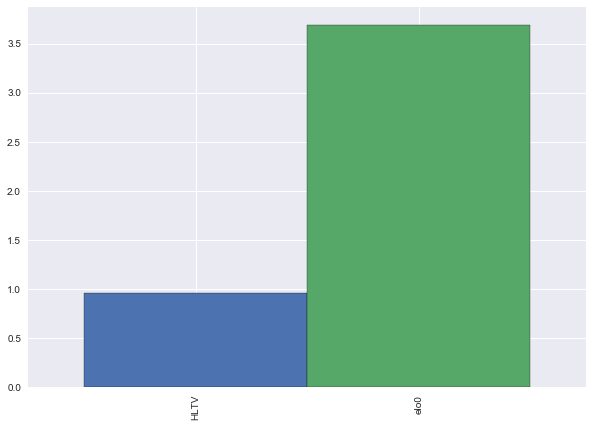

In [45]:
# LogisticRegression
trIndex = newdf.iloc[:int(newdf.shape[0]*0.7)].index
teIndex = newdf.iloc[int(newdf.shape[0]*0.7):].index


LogReCmn = LogisticRegression()
LogReCmn.fit(stack1lvl.loc[trIndex, linreCmnCols].values, newdf.loc[trIndex, 'difScore'].values>0)
joblib.dump(LogReCmn, './models/StackCmnLr_1000_28copy')
preTr = LogReCmn.predict_proba(stack1lvl.loc[trIndex, linreCmnCols].values).T[1]
preTe = LogReCmn.predict_proba(stack1lvl.loc[teIndex, linreCmnCols].values).T[1]
print('cmn')
# print(predCmn)
# print('MSE', mean_squared_error(predCmn, df.loc[teIndex, 'difScore'].values))
# print('MAE', mean_absolute_error(predCmn, df.loc[teIndex, 'difScore'].values))
print 'TRAIN accuracy', accuracy_score(newdf.loc[trIndex, 'difScore'].values>0, preTr>0.5), 'ROC-AUC', roc_auc_score(newdf.loc[trIndex, 'difScore'].values>0, preTr)
print 'TEST accuracy', accuracy_score(preTe>0.5, newdf.loc[teIndex, 'difScore'].values>0), 'ROC-AUC', roc_auc_score(newdf.loc[teIndex, 'difScore'].values>0, preTe)
print LogReCmn.coef_

pd.Series(LogReCmn.coef_[0], index=linreCmnCols).plot.bar(width=1, edgecolor='black', figsize=(10,7))

In [203]:
stack1lvl.iloc[:, :7].corr()

,HLTV,elo0,elo0Inf,glicko,glicko2,trueskill,trueskillUnrate
HLTV,1.000000,0.730913,0.739772,0.712364,0.723699,0.719760,0.734808
elo0,0.730913,1.000000,0.974444,0.915748,0.934608,0.930412,0.920949
elo0Inf,0.739772,0.974444,1.000000,0.925266,0.938839,0.928264,0.925611
glicko,0.712364,0.915748,0.925266,1.000000,0.937715,0.925873,0.928741
glicko2,0.723699,0.934608,0.938839,0.937715,1.000000,0.940283,0.941124
trueskill,0.719760,0.930412,0.928264,0.925873,0.940283,1.000000,0.959739
trueskillUnrate,0.734808,0.920949,0.925611,0.928741,0.941124,0.959739,1.000000


In [46]:
if 'map' in stack1lvl.columns.values:
    stack1lvl.drop([u'matchlinkId', u'map', u'teamAId', u'teamBId'], axis=1, inplace=True)

In [47]:
ids = pd.read_csv('./data/matchLinkIds.csv', sep=';')
newIndex = np.arange(ids.shape[0])
newIndex[::2] = ids.index.values[:ids.shape[0]//2]
newIndex[1::2] = ids.index.values[ids.shape[0]//2:]
ids.loc[ids.index] = ids.loc[newIndex].values
ids.reset_index(drop=True, inplace=True)
ids = ids.iloc[int(ids.shape[0]*0.1):]
ids.reset_index(drop=True, inplace=True)
# ids = ids.iloc[int(ids.shape[0]*0.1):]
# ids.reset_index(drop=True, inplace=True)
ids.shape, df.shape, stack1lvl.shape


((95044, 4), (105604, 287), (95044, 2))

In [48]:
stack1lvl = pd.merge(stack1lvl, ids, left_index=True, right_index=True)

# In the rest of this notebook we check our model - how much money we can get using this model if we would bet on median of multiple bookmakers coeficients.

## In the next cell we define multiple betting strategies and makeBet function. In makeBet function we bet on the result with the probaility >0.5 predicted by our model and bet 500 conventional unit.

In [61]:
def fixBet(aKef, bKef, aPer, bPer, aPred, bet, isWin, expWin=0, border=0): #
    if aPred>0.5:
        if aKef<border:
            return 0
        if isWin:
            return bet*aKef-bet
        else:
            return -bet
    elif aPred<0.5:
        if bKef<border:
            return 0
        if not isWin:
            return bet*bKef-bet
        else:
            return -bet
    return 0

def flexBet(aKef, bKef, aPer, bPer, aPred, bet, isWin, expWin=0, border=0):
    if aPred>0.5:
        if aKef<border:
            return 0
        if expWin:
            bet = expWin/max(0.01, (aKef - 1))
        if isWin:
            return bet*aKef-bet
        else:
            return -bet
    elif aPred<0.5:
        if bKef<border:
            return 0
        if expWin:
            bet = expWin/max(0.01, (bKef - 1))
        if not isWin:
            return bet*bKef-bet
        else:
            return -bet
    return 0

def flexBetV2(aKef, bKef, aPer, bPer, aPred, bet, isWin, expWin=0, border=0):
    # unused
    if aPred>aPer and aPred>0.5:
        if isWin:
            return bet*aKef-bet
        else:
            return -bet
#     elif aPred<0.5:
#         if not isWin:
#             return bet*bKef
#         else:
#             return -bet
    return 0

def flexBetV31(aKef, bKef, aPer, bPer, aPred, bet, isWin, expWin=0, border=0):
    # flexBet but with restrictions
    if aPred>0.5:
        if aKef<border:
            return 0
        if expWin:
            bet = min(1000, expWin/max(0.01, (aKef - 1)))
        if isWin:
            return bet*aKef-bet
        else:
            return -bet
    elif aPred<0.5:
        if bKef<border:
            return 0
        if expWin:
            bet = min(1000, expWin/max(0.01, (bKef - 1)))
        if not isWin:
            return bet*bKef-bet
        else:
            return -bet
    return 0

def flexBetV4(aKef, bKef, aPer, bPer, aPred, bet, isWin, expWin=0, border=0):
    if aPred>0.5:
        if aKef<border:
            return 0
        bet += bet*(aPred-aPer)
#         bet = min(1000, bet)
#         if expWin:
#             bet = max(5000, expWin/max(0.01, (aKef - 1)))
        if isWin:
            return bet*aKef-bet
        else:
            return -bet
    elif aPred<0.5:
        if bKef<border:
            return 0
        bet += bet*(1-aPred-bPer)
#         bet = min(1000, bet)
#         if expWin:
#             bet = max(5000, expWin/max(0.01, (bKef - 1)))
        if not isWin:
            return bet*bKef-bet
        else:
            return -bet
    return 0


def makeBet(linRe, linreCols, x, betFunc, bet, expWin=0, border=0, bo=0, mode='log'):
    tmpIndex = stack1lvl[(stack1lvl['matchlinkId']==x['matchLinkId']) & (stack1lvl['teamAId']==x['teamAId']) & (stack1lvl['teamBId']==x['teamBId'])].index
    tmp = stack1lvl.loc[tmpIndex]
    if tmp.shape[0] in [1, 3]:
        if mode=='reg':
            predA = np.maximum(-16, np.minimum(16, linRe.predict(tmp[linreCols].values)))/32.0 + 0.5
        elif mode=='log':
            predA = linRe.predict_proba(tmp[linreCols].values).T[1]
        else:
            predA = tmp['HLTV'].values
#             print predA, np.maximum(-16, np.minimum(16, linRe.predict(tmp[linreCols].values)))/32.0 + 0.5
        if tmp.shape[0]==1 and (tmp.shape[0]==bo or not bo):
            totalA = predA[0]
            isWin = (newdf.loc[tmpIndex, 'difScore'].values>0).sum()>0
        elif tmp.shape[0]<=3 and (tmp.shape[0]==bo or not bo):
            isWin = (newdf.loc[tmpIndex, 'difScore'].values>0).sum()>=2
            predB = 1 - predA
            totalA = predA[0]*predA[1] + predA[0]*(1-predA[1])*predA[2] + (1-predA[0])*predA[1]*predA[2]
            totalB = predB[0]*predB[1] + predB[0]*(1-predB[1])*predB[2] + (1-predB[0])*predB[1]*predB[2]
#             print(totalA, totalB, totalA+totalB)
            if totalA+totalB!=1:
                totalA = totalA/(totalA+totalB)
                totalB = 1 - totalA
            
#             ret = betFunc(x['teamAkef'], x['teamBkef'], x['teamAperMarja'], x['teamBperMarja'], totalA, bet, isWin, expWin, border)
#             print(df.loc[tmpIndex, 'difScore'].values, (df.loc[tmpIndex, 'difScore'].values>0).sum(), isWin, round(totalA, 4), 'aKef: %s, bKef: %s'%(x['teamAkef'], x['teamBkef']), ret)
        else:
#             print x.shape, x
#             assert False
            return 0
        ret = betFunc(x['teamAkef'], x['teamBkef'], x['teamAperMarja'], x['teamBperMarja'], totalA, bet, isWin, expWin, border)
        return ret
#     print tmp.shape
#     assert False
    return 0
    

In [78]:
kefs = pd.read_csv('./data/csgoKefs.csv', sep=';')
kefs['kefs'] = kefs['kefs'].apply(lambda x: np.array(ast.literal_eval(x)))
kefs['teamAkef'] = kefs['kefs'].apply(lambda x: np.median(x.T[0]))#np.median min max np.maximum(1.01, min(x.T[0]))
kefs['teamBkef'] = kefs['kefs'].apply(lambda x: np.median(x.T[1]))#np.median min max np.maximum(1.01, min(x.T[1]))
kefs['teamAperMarja'] = 1/kefs['teamAkef'].values
kefs['teamBperMarja'] = 1/kefs['teamBkef'].values
kefs['teamAper'] = kefs['teamAperMarja'].values/(kefs['teamAperMarja'].values + kefs['teamBperMarja'].values)
kefs['teamBper'] = kefs['teamBperMarja'].values/(kefs['teamAperMarja'].values + kefs['teamBperMarja'].values)

# kefs['teamAkef'] = kefs['kefs'].apply(lambda x: np.min(x.T[0]))
# kefs['teamBkef'] = kefs['kefs'].apply(lambda x: np.min(x.T[1]))

kefs['teamAkef'] = np.minimum(kefs['teamAkef'].values, [7]*kefs.shape[0])
kefs['teamBkef'] = np.minimum(kefs['teamBkef'].values, [7]*kefs.shape[0])
kefs.drop_duplicates(['matchLinkId', u'teamAId', u'teamBId'], inplace=True)
print kefs.shape
j = list(set(kefs[u'matchLinkId'].values) - set(stack1lvl[u'matchlinkId'].values))
kefs.drop(kefs[kefs['matchLinkId'].isin(j)].index, inplace=True)
kefs.shape

(8168, 10)


(7942, 10)

In [80]:
kefs['matchLinkId'].max(), kefs['matchLinkId'].min()

(2332013, 2319592)

## ALL MATCHES. Output format - (totalWin, number of wrong predictions, number of right predictions, accuracy, number of predictions)

## fixBet

In [62]:
# logReg all ratingSystems #BO1
flexV31 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, fixBet, 500, 500, 1, bo=1, mode='log'), axis=1)
flexV31.sum(), flexV31[flexV31<0].count(), flexV31[flexV31>0].count(), 1-flexV31[flexV31<0].count()/float(flexV31[(flexV31<0) | (flexV31>0)].count()), flexV31[(flexV31<0) | (flexV31>0)].count()

(-64455.0, 1257, 2620, 0.6757802424555068, 3877)

In [63]:
# logReg all ratingSystems #BO3
flexV31 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, fixBet, 500, 500, 1, bo=3, mode='log'), axis=1)
flexV31.sum(), flexV31[flexV31<0].count(), flexV31[flexV31>0].count(), 1-flexV31[flexV31<0].count()/float(flexV31[(flexV31<0) | (flexV31>0)].count()), flexV31[(flexV31<0) | (flexV31>0)].count()

(-20667.5, 531, 870, 0.6209850107066381, 1401)

## flexBet

In [64]:
# logReg all ratingSystems #BO1
flexV31 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBet, 500, 500, 1, bo=1, mode='log'), axis=1)
flexV31.sum(), flexV31[flexV31<0].count(), flexV31[flexV31>0].count(), 1-flexV31[flexV31<0].count()/float(flexV31[(flexV31<0) | (flexV31>0)].count()), flexV31[(flexV31<0) | (flexV31>0)].count()

(-82620.44019858894, 1257, 2620, 0.6757802424555068, 3877)

In [65]:
# logReg all ratingSystems #BO3
flexV31 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBet, 500, 500, 1, bo=3, mode='log'), axis=1)
flexV31.sum(), flexV31[flexV31<0].count(), flexV31[flexV31>0].count(), 1-flexV31[flexV31<0].count()/float(flexV31[(flexV31<0) | (flexV31>0)].count()), flexV31[(flexV31<0) | (flexV31>0)].count()

(-173811.90740929975, 531, 870, 0.6209850107066381, 1401)

## flexBetV31

In [66]:
# logReg all ratingSystems #BO1
flexV31 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBetV31, 500, 500, 1, bo=1, mode='log'), axis=1)
flexV31.sum(), flexV31[flexV31<0].count(), flexV31[flexV31>0].count(), 1-flexV31[flexV31<0].count()/float(flexV31[(flexV31<0) | (flexV31>0)].count()), flexV31[(flexV31<0) | (flexV31>0)].count()

(-118967.1577116389, 1257, 2620, 0.6757802424555068, 3877)

In [67]:
# logReg all ratingSystems #BO3
flexV31 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBetV4, 500, 500, 1, bo=3, mode='log'), axis=1)
flexV31.sum(), flexV31[flexV31<0].count(), flexV31[flexV31>0].count(), 1-flexV31[flexV31<0].count()/float(flexV31[(flexV31<0) | (flexV31>0)].count()), flexV31[(flexV31<0) | (flexV31>0)].count()

(-9150.161234078176, 531, 870, 0.6209850107066381, 1401)

## flexBetV4

In [68]:
# logReg all ratingSystems #BO1
flexV31 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBetV4, 500, 500, 1, bo=1, mode='log'), axis=1)
flexV31.sum(), flexV31[flexV31<0].count(), flexV31[flexV31>0].count(), 1-flexV31[flexV31<0].count()/float(flexV31[(flexV31<0) | (flexV31>0)].count()), flexV31[(flexV31<0) | (flexV31>0)].count()

(-61279.6209916261, 1257, 2620, 0.6757802424555068, 3877)

In [69]:
# logReg all ratingSystems #BO3
flexV31 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBetV4, 500, 500, 1, bo=3, mode='log'), axis=1)
flexV31.sum(), flexV31[flexV31<0].count(), flexV31[flexV31>0].count(), 1-flexV31[flexV31<0].count()/float(flexV31[(flexV31<0) | (flexV31>0)].count()), flexV31[(flexV31<0) | (flexV31>0)].count()

(-9150.161234078176, 531, 870, 0.6209850107066381, 1401)

# Testing on matches with bookmakers coef restriction (make a bet on outcome with coef >= 1.7 in a case below)

## fixBet

In [70]:
# logReg all ratingSystems #BO1
flexV31 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, fixBet, 500, 500, 1.7, bo=1, mode='log'), axis=1)
flexV31.sum(), flexV31[flexV31<0].count(), flexV31[flexV31>0].count(), 1-flexV31[flexV31<0].count()/float(flexV31[(flexV31<0) | (flexV31>0)].count()), flexV31[(flexV31<0) | (flexV31>0)].count()

(3737.5, 419, 396, 0.4858895705521472, 815)

In [71]:
# logReg all ratingSystems #BO3
flexV31 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, fixBet, 500, 500, 1.7, bo=3, mode='log'), axis=1)
flexV31.sum(), flexV31[flexV31<0].count(), flexV31[flexV31>0].count(), 1-flexV31[flexV31<0].count()/float(flexV31[(flexV31<0) | (flexV31>0)].count()), flexV31[(flexV31<0) | (flexV31>0)].count()

(29590.0, 198, 217, 0.5228915662650602, 415)

## flexBet

In [72]:
# logReg all ratingSystems #BO1
flexV31 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBet, 500, 500, 1.7, bo=1, mode='log'), axis=1)
flexV31.sum(), flexV31[flexV31<0].count(), flexV31[flexV31>0].count(), 1-flexV31[flexV31<0].count()/float(flexV31[(flexV31<0) | (flexV31>0)].count()), flexV31[(flexV31<0) | (flexV31>0)].count()

(3504.186537803609, 419, 396, 0.4858895705521472, 815)

In [73]:
# logReg all ratingSystems #BO3
flexV31 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBet, 500, 500, 1.7, bo=3, mode='log'), axis=1)
flexV31.sum(), flexV31[flexV31<0].count(), flexV31[flexV31>0].count(), 1-flexV31[flexV31<0].count()/float(flexV31[(flexV31<0) | (flexV31>0)].count()), flexV31[(flexV31<0) | (flexV31>0)].count()

(21716.80184552763, 198, 217, 0.5228915662650602, 415)

## flexBetV31

In [74]:
# logReg all ratingSystems #BO1
flexV31 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBetV31, 500, 500, 1.7, bo=1, mode='log'), axis=1)
flexV31.sum(), flexV31[flexV31<0].count(), flexV31[flexV31>0].count(), 1-flexV31[flexV31<0].count()/float(flexV31[(flexV31<0) | (flexV31>0)].count()), flexV31[(flexV31<0) | (flexV31>0)].count()

(3504.186537803609, 419, 396, 0.4858895705521472, 815)

In [75]:
# logReg all ratingSystems #BO3
flexV31 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBetV4, 500, 500, 1.7, bo=3, mode='log'), axis=1)
flexV31.sum(), flexV31[flexV31<0].count(), flexV31[flexV31>0].count(), 1-flexV31[flexV31<0].count()/float(flexV31[(flexV31<0) | (flexV31>0)].count()), flexV31[(flexV31<0) | (flexV31>0)].count()

(35970.83964239305, 198, 217, 0.5228915662650602, 415)

## flexBetV4

In [76]:
# logReg all ratingSystems #BO1
flexV31 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBetV4, 500, 500, 1.7, bo=1, mode='log'), axis=1)
flexV31.sum(), flexV31[flexV31<0].count(), flexV31[flexV31>0].count(), 1-flexV31[flexV31<0].count()/float(flexV31[(flexV31<0) | (flexV31>0)].count()), flexV31[(flexV31<0) | (flexV31>0)].count()

(4859.676766422759, 419, 396, 0.4858895705521472, 815)

In [77]:
# logReg all ratingSystems #BO3
flexV31 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBetV4, 500, 500, 1.7, bo=3, mode='log'), axis=1)
flexV31.sum(), flexV31[flexV31<0].count(), flexV31[flexV31>0].count(), 1-flexV31[flexV31<0].count()/float(flexV31[(flexV31<0) | (flexV31>0)].count()), flexV31[(flexV31<0) | (flexV31>0)].count()

(35970.83964239305, 198, 217, 0.5228915662650602, 415)

## As you can see from results, the model can make us some income with a specific betting restrictions and strategy. Coeficients from multiple bookmakers were parsed for about 1 year period from HLTV within 30 minutes before starting a match. Although you can make a bot making a bet according to this model and get passive income, but for me the risk of getting the ban from bookmakers for auto betting and loosing a lot of money is higher comparing to possible income from the model (before started the project, my expectations about possible income were pretty higher). Also there can be some bugs or leaks in my code and possible income can be actually less comparing to your expectations and my results :) Use it on your own risk!!

## Below you can adjust border parameter to maximaze the possible income during testing.

In [56]:
#BO1
for border in np.arange(1.0, 2.1, .05):
    print 'BORDER', border
    fixBet123 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, fixBet, 500, 500, border=border, bo=1, mode='log'), axis=1)
    flexBet123 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBet, 500, 500, border=border, bo=1, mode='log'), axis=1)
    flexBetV31123 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBetV31, 500, 500, border=border, bo=1, mode='log'), axis=1)
    flexBetV4123 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBetV4, 500, 500, border=border, bo=1, mode='log'), axis=1)
    
    print 'fixBet:', fixBet123.sum(), 'flexBet:', flexBet123.sum(), 'flexBetV31:', flexBetV31123.sum(), 'flexBetV4:', flexBetV4123.sum(), 'REST:', flexBetV4123[flexBetV4123<0].count(), flexBetV4123[flexBetV4123>0].count(), 1-flexBetV4123[flexBetV4123<0].count()/float(flexBetV4123[(flexBetV4123<0) | (flexBetV4123>0)].count()), flexBetV4123[(flexBetV4123<0) | (flexBetV4123>0)].count()

BORDER 1.0
fixBet: -58542.5 flexBet: -76073.92588393358 flexBetV31: -111564.18942657768 flexBetV4: -55791.47015801995 REST: 1250 2627 0.6775857621872582 3877
BORDER 1.05
fixBet: -59067.5 flexBet: -95407.25921726692 flexBetV31: -112614.18942657768 flexBetV4: -56250.73263626472 REST: 1249 2555 0.6716614090431126 3804
BORDER 1.1
fixBet: -62050.0 flexBet: -135651.820211828 flexBetV31: -118579.18942657768 flexBetV4: -58914.18996925382 REST: 1243 2384 0.6572925282602702 3627
BORDER 1.1500000000000001
fixBet: -64820.0 flexBet: -156399.26730635157 flexBetV31: -124119.18942657768 flexBetV4: -61277.79901995962 REST: 1219 2145 0.6376337693222354 3364
BORDER 1.2000000000000002
fixBet: -63312.5 flexBet: -150211.20467169446 flexBetV31: -121104.18942657768 flexBetV4: -60117.132189835844 REST: 1177 1931 0.6212998712998713 3108
BORDER 1.2500000000000002
fixBet: -55562.5 flexBet: -115738.67979298113 flexBetV31: -105604.18942657768 flexBetV4: -53190.671315373314 REST: 1116 1735 0.6085584005612066 2851
BO

In [57]:
#BO3
for border in np.arange(1, 2.1, .05):
    print 'BORDER', border
    fixBet123 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, fixBet, 500, 500, border=border, bo=3, mode='log'), axis=1)
    flexBet123 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBet, 500, 500, border=border, bo=3, mode='log'), axis=1)
    flexBetV31123 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBetV31, 500, 500, border=border, bo=3, mode='log'), axis=1)
    flexBetV4123 = kefs.apply(lambda x: makeBet(LogReCmn, linreCmnCols, x, flexBetV4, 500, 500, border=border, bo=3, mode='log'), axis=1)
    
    print 'fixBet:', fixBet123.sum(), 'flexBet:', flexBet123.sum(), 'flexBetV31:', flexBetV31123.sum(), 'flexBetV4:', flexBetV4123.sum(), 'REST:', flexBetV4123[flexBetV4123<0].count(), flexBetV4123[flexBetV4123>0].count(), 1-flexBetV4123[flexBetV4123<0].count()/float(flexBetV4123[(flexBetV4123<0) | (flexBetV4123>0)].count()), flexBetV4123[(flexBetV4123<0) | (flexBetV4123>0)].count()

BORDER 1.0
fixBet: -36155.0 flexBet: -192340.93250464858 flexBetV31: -97779.43095039992 flexBetV4: -23649.372255728915 REST: 546 855 0.6102783725910064 1401
BORDER 1.05
fixBet: -36270.0 flexBet: -196840.93250464858 flexBetV31: -98009.43095039992 flexBetV4: -23753.71538181224 REST: 546 846 0.6077586206896552 1392
BORDER 1.1
fixBet: -34267.5 flexBet: -171313.15472687082 flexBetV31: -94004.43095039992 flexBetV4: -21942.08393732638 REST: 540 819 0.6026490066225165 1359
BORDER 1.1500000000000001
fixBet: -31242.5 flexBet: -145287.10670082283 flexBetV31: -87954.43095039992 flexBetV4: -19473.160394075014 REST: 527 765 0.5921052631578947 1292
BORDER 1.2000000000000002
fixBet: -27077.5 flexBet: -123196.86038418328 flexBetV31: -79624.43095039992 flexBetV4: -15450.04211140489 REST: 509 712 0.5831285831285831 1221
BORDER 1.2500000000000002
fixBet: -24112.5 flexBet: -109853.75790403069 flexBetV31: -73694.43095039992 flexBetV4: -12792.82327924012 REST: 486 639 0.5680000000000001 1125
BORDER 1.3000000